### Intrusion Detection ###

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans




In [2]:
df_data = pd.read_csv('data\Wednesday-workingHours-pcap_ISCX.csv')
print(df_data.shape)
df_data.head()

<>:1: SyntaxWarning: invalid escape sequence '\W'
<>:1: SyntaxWarning: invalid escape sequence '\W'
C:\Users\arunk\AppData\Local\Temp\ipykernel_6360\3119943531.py:1: SyntaxWarning: invalid escape sequence '\W'
  df_data = pd.read_csv('data\Wednesday-workingHours-pcap_ISCX.csv')


(692703, 85)


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.14-209.48.71.168-49459-80-6,192.168.10.14,49459,209.48.71.168,80,6,5/7/2017 8:42,38308,1,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.3-192.168.10.17-389-49453-6,192.168.10.17,49453,192.168.10.3,389,6,5/7/2017 8:42,479,11,5,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.3-192.168.10.17-88-46124-6,192.168.10.17,46124,192.168.10.3,88,6,5/7/2017 8:42,1095,10,6,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.3-192.168.10.17-389-49454-6,192.168.10.17,49454,192.168.10.3,389,6,5/7/2017 8:42,15206,17,12,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.3-192.168.10.17-88-46126-6,192.168.10.17,46126,192.168.10.3,88,6,5/7/2017 8:42,1092,9,6,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [3]:
df_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692703 entries, 0 to 692702
Data columns (total 85 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Flow ID                       692703 non-null  object 
 1    Source IP                    692703 non-null  object 
 2    Source Port                  692703 non-null  int64  
 3    Destination IP               692703 non-null  object 
 4    Destination Port             692703 non-null  int64  
 5    Protocol                     692703 non-null  int64  
 6    Timestamp                    692703 non-null  object 
 7    Flow Duration                692703 non-null  int64  
 8    Total Fwd Packets            692703 non-null  int64  
 9    Total Backward Packets       692703 non-null  int64  
 10  Total Length of Fwd Packets   692703 non-null  int64  
 11   Total Length of Bwd Packets  692703 non-null  float64
 12   Fwd Packet Length Max        692703 non-nul

In [4]:
# There are 692K records, which we are goig to reduce to 100K maintining the proportion. This will allow for training without extensive compute requriement.
# After creating a sample with 100K records, we will save sample dataframe to a csv file, that might come handy during later phases of model development

output_file = "data\Wednesday-workingHours-pcap_ISCX_processed.csv"  
column_name = "Label"
sample_size = 100000

# Check if the column exists
if column_name not in df_data.columns:
    print(f"Error: Column '{column_name}' not found in the Excel file.")
else:
    # Group the data by the specified column and calculate sampling proportions
    proportions = df_data[column_name].value_counts(normalize=True)
    
    # Sample records while maintaining the proportions
    df_sample = pd.DataFrame()
    for category, proportion in proportions.items():
        n_samples = int(proportion * sample_size)  # Calculate number of samples for each category
        category_sample = df_data[df_data[column_name] == category].sample(n=n_samples, random_state=42)
        df_sample = pd.concat([df_sample, category_sample], ignore_index=True)
    
    # Shuffle the resulting sampled dataframe
    df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)

    # Save the sampled data to a new csv data file
    df_sample.to_csv(output_file, index=False)
    print(f"Sampled data saved to '{output_file}'!") 

<>:4: SyntaxWarning: invalid escape sequence '\W'
<>:4: SyntaxWarning: invalid escape sequence '\W'
C:\Users\arunk\AppData\Local\Temp\ipykernel_6360\995062789.py:4: SyntaxWarning: invalid escape sequence '\W'
  output_file = "data\Wednesday-workingHours-pcap_ISCX_processed.csv"


Sampled data saved to 'data\Wednesday-workingHours-pcap_ISCX_processed.csv'!


In [5]:
# Identify unique values in [Label] column.
unique_values = df_sample['Label'].unique()
print(unique_values)


['BENIGN' 'DoS Hulk' 'DoS GoldenEye' 'DoS slowloris' 'DoS Slowhttptest'
 'Heartbleed']


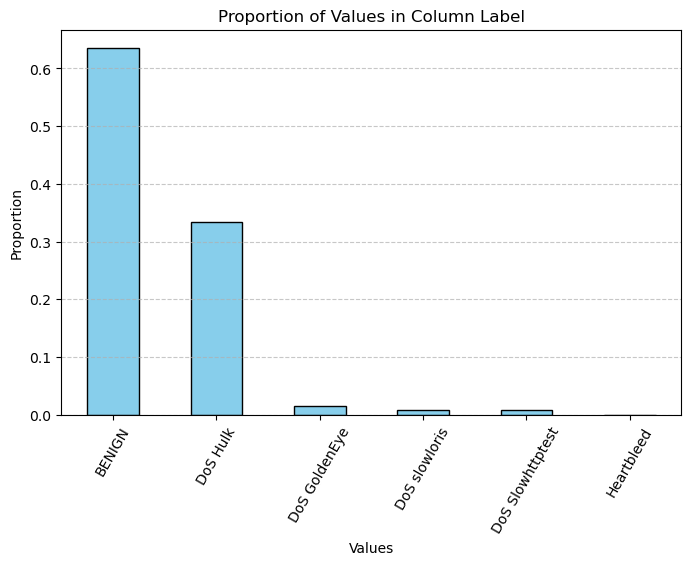

In [6]:
plt.figure(figsize=(8, 5))
proportions.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Proportion of Values in Column Label")
plt.xlabel("Values")
plt.ylabel("Proportion")
plt.xticks(rotation=60)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [7]:
# Convert [Label] column values into integer with BENIGN being 0 and rest to 1

mapping = {
    "BENIGN": 0,
    "DoS Hulk": 1,
    "DoS GoldenEye": 1,
    "DoS slowloris": 1,
    "DoS Slowhttptest": 1,
    "Heartbleed": 1
}

# Apply mapping to [Label] column
df_sample['Label'] = df_sample['Label'].map(mapping)
unique_values = df_sample['Label'].unique()
print(unique_values)


[0 1]


In [8]:
# Replace 'Infinity' and other string issues with actual np.nan
df_sample.replace(['Infinity', 'NaN', 'nan', 'NaN ', ' NAN'], np.nan, inplace=True)

# Drop columns with all NaNs or a single unique value
df_sample.dropna(axis=1, how='all', inplace=True)
for col in df_sample.columns:
    if df_sample[col].nunique() <= 1:
        df_sample.drop(columns=col, inplace=True)

# Strip whitespace from all column names
df_sample.columns = df_sample.columns.str.strip()

# Drop rows with any missing values
df_sample.dropna(inplace=True)

df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99851 entries, 0 to 99995
Data columns (total 75 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flow ID                      99851 non-null  object 
 1   Source IP                    99851 non-null  object 
 2   Source Port                  99851 non-null  int64  
 3   Destination IP               99851 non-null  object 
 4   Destination Port             99851 non-null  int64  
 5   Protocol                     99851 non-null  int64  
 6   Timestamp                    99851 non-null  object 
 7   Flow Duration                99851 non-null  int64  
 8   Total Fwd Packets            99851 non-null  int64  
 9   Total Backward Packets       99851 non-null  int64  
 10  Total Length of Fwd Packets  99851 non-null  int64  
 11  Total Length of Bwd Packets  99851 non-null  float64
 12  Fwd Packet Length Max        99851 non-null  int64  
 13  Fwd Packet Length Min

In [9]:
# Converting Source IP and Destination IP columns from object to float. For this we will remove the periods in IP addresses
df_sample['Source IP'] = df_sample['Source IP'].str.replace('.', '').astype(float)
df_sample['Destination IP'] = df_sample['Destination IP'].str.replace('.', '').astype(float)

# Convert [Timestamp] column which is in Object form to float epoch time
df_sample['Timestamp'] = pd.to_datetime(df_sample['Timestamp']).apply(lambda x: x.timestamp())

df_sample[['Timestamp', 'Source IP', 'Destination IP']].head()


,Timestamp,Source IP,Destination IP
0,1.494157e+09,1.921681e+09,1.921681e+08
1,1.494126e+09,1.921681e+08,1.921681e+08
2,1.494155e+09,5.284261e+08,1.921681e+09
3,1.494157e+09,1.921681e+09,5.233209e+09
4,1.494121e+09,1.921681e+09,1.921681e+08


In [10]:
# Dropping Flow ID column as it has no impact on whether the traffic is Benign or Harmful
df_sample = df_sample.drop(columns=['Flow ID'])

df_sample.info()


<class 'pandas.core.frame.DataFrame'>
Index: 99851 entries, 0 to 99995
Data columns (total 74 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Source IP                    99851 non-null  float64
 1   Source Port                  99851 non-null  int64  
 2   Destination IP               99851 non-null  float64
 3   Destination Port             99851 non-null  int64  
 4   Protocol                     99851 non-null  int64  
 5   Timestamp                    99851 non-null  float64
 6   Flow Duration                99851 non-null  int64  
 7   Total Fwd Packets            99851 non-null  int64  
 8   Total Backward Packets       99851 non-null  int64  
 9   Total Length of Fwd Packets  99851 non-null  int64  
 10  Total Length of Bwd Packets  99851 non-null  float64
 11  Fwd Packet Length Max        99851 non-null  int64  
 12  Fwd Packet Length Min        99851 non-null  int64  
 13  Fwd Packet Length Mea

In [11]:

# Calculate min, max, and range for each column
min_values = df_sample.min()
max_values = df_sample.max()
range_values = max_values - min_values

summary_df = pd.DataFrame({
    'Min': min_values,
    'Max': max_values,
    'Range': range_values
})

sorted_summary_df = summary_df.sort_values(by='Range', ascending=False)

print("Summary (sorted by Range in descending order):")
print(sorted_summary_df)

Summary (sorted by Range in descending order):
                                    Min           Max         Range
Flow Packets/s               -2000000.0           inf           inf
Flow Bytes/s                -12000000.0           inf           inf
Destination IP                   8064.0  2.552553e+11  2.552552e+11
Source IP                        8601.0  2.221612e+11  2.221612e+11
Total Length of Bwd Packets         0.0  4.540000e+08  4.540000e+08
...                                 ...           ...           ...
RST Flag Count                      0.0  1.000000e+00  1.000000e+00
SYN Flag Count                      0.0  1.000000e+00  1.000000e+00
FIN Flag Count                      0.0  1.000000e+00  1.000000e+00
Fwd PSH Flags                       0.0  1.000000e+00  1.000000e+00
Label                               0.0  1.000000e+00  1.000000e+00

[74 rows x 3 columns]


In [12]:
# As [Flow Packets/s] and [Flow Bytes/s] have Max value of infinity and range of infinity, we will drop these columns from data set
df_sample = df_sample.drop(columns=['Flow Packets/s', 'Flow Bytes/s'])

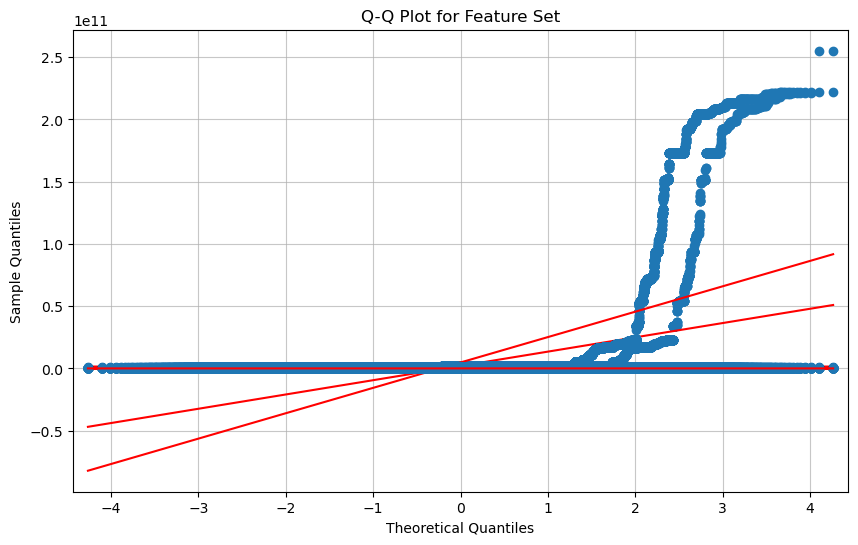

In [13]:
# Creating Q-Q plot for Feature set X to determine data set distribution is Normal or not.
 
plt.figure(figsize=(10, 6))
for column in df_sample.columns:
    sm.qqplot(df_sample[column], line='s', ax=plt.gca(), label=column)

plt.title("Q-Q Plot for Feature Set")
plt.grid(alpha=0.7)
plt.show()



Principal Components DataFrame:
              0         1         2         3         4
0     -0.739309 -0.287952 -0.433229  0.224853 -0.041177
1     -0.825783 -0.407209 -0.498043  0.102386 -0.277206
2     -0.702949  1.015347  0.156072 -0.636160  0.316439
3     -0.508394 -0.574938  0.749371  0.102983  0.001010
4     -0.890994 -0.240765 -0.433519 -0.205765 -0.148584
...         ...       ...       ...       ...       ...
99846 -0.739209 -0.635204  0.568615 -0.041203 -0.142461
99847 -0.702203  1.023732  0.153237 -0.670732  0.341426
99848  1.954457  0.471897 -0.032506  0.174956 -0.565860
99849 -0.663666  0.813107  0.182610 -0.400047  0.210026
99850 -0.775968 -0.329255 -0.462970  0.247424 -0.102223

[99851 rows x 5 columns]

Explained Variance Ratio:
[0.45485186 0.1530922  0.07867782 0.07556715 0.04984632]
DataFrame with PCA components, and Clusters:
       PCA1      PCA2      PCA3      PCA4      PCA5  Cluster
0 -0.739309 -0.287952 -0.433229  0.224853 -0.041177        1
1 -0.825783 -0.407

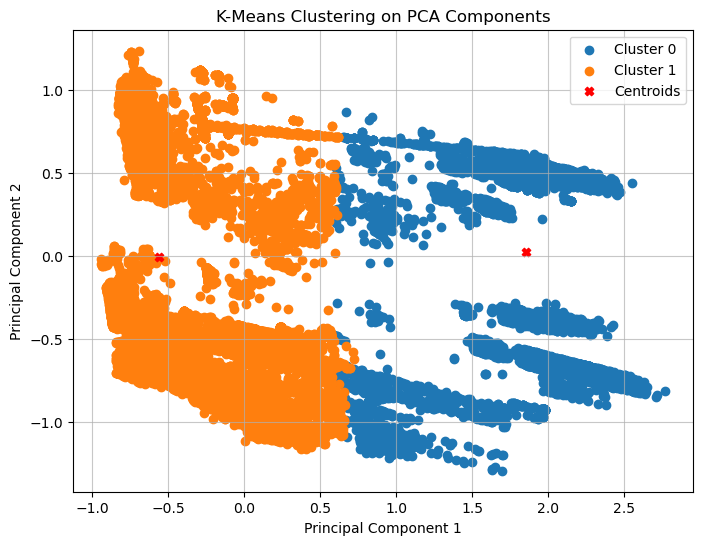

In [14]:
# There are 70+ features that need to be reduced. We will start with doing Principal Component Analysis(PCA) to reduce features and then cluster them into 2 clusters. 
# Creating a dataframe without the target column [Label]

#features = df_sample.drop(columns=['Label'])
#target = df_sample['Label']

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_sample)

pca = PCA(n_components=5)  # reducing to 5 principal components
pca_data = pca.fit_transform(scaled_features)

df_pca = pd.DataFrame(pca_data)

print("\nPrincipal Components DataFrame:")
print(df_pca)

explained_variance = pca.explained_variance_ratio_
print("\nExplained Variance Ratio:")
print(explained_variance)


kmeans = KMeans(n_clusters=2, random_state=42) # clustering into 2
clusters = kmeans.fit_predict(pca_data)

pca_df = pd.DataFrame(pca_data, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'])
pca_df['Cluster'] = clusters

print("DataFrame with PCA components, and Clusters:")
print(pca_df.head())

X = pca_df.drop(columns=['Cluster'])  # Features (PCA components and cluster)
y = pca_df['Cluster']  # Target column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining and Test Sets Created!")
print(f"Training Set Size: {X_train.shape[0]}, Test Set Size: {X_test.shape[0]}")


plt.figure(figsize=(8, 6))
for cluster_id in range(2):  # Number of clusters
    clustered_points = pca_df[pca_df['Cluster'] == cluster_id]
    plt.scatter(clustered_points['PCA1'], clustered_points['PCA2'], label=f'Cluster {cluster_id}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            color='red', marker='X', label='Centroids')  # Centroids
plt.title("K-Means Clustering on PCA Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(alpha=0.7)
plt.show()


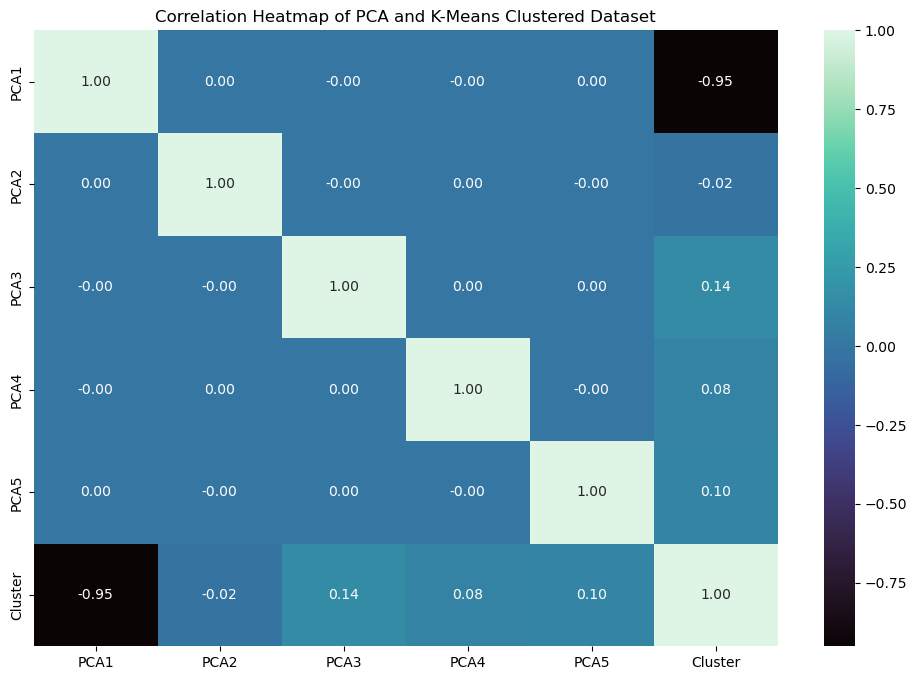

In [15]:
# Compute correlation matrix
corr = pca_df.corr(numeric_only=True)

# Plot heatmap 
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='mako')
plt.title("Correlation Heatmap of PCA and K-Means Clustered Dataset")
plt.show()


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4681
           1       1.00      1.00      1.00     15290

    accuracy                           1.00     19971
   macro avg       1.00      1.00      1.00     19971
weighted avg       1.00      1.00      1.00     19971



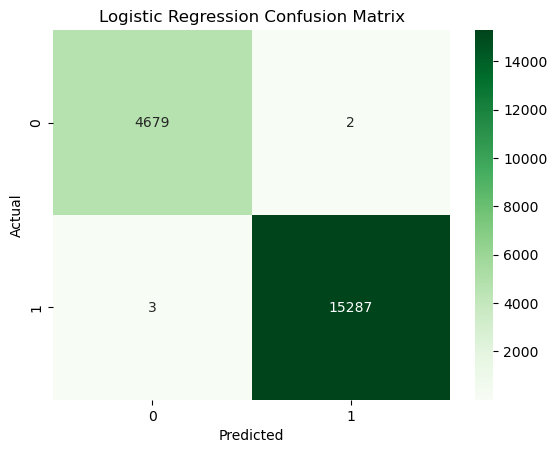

Logistic Regression ROC AUC Score: 1.0


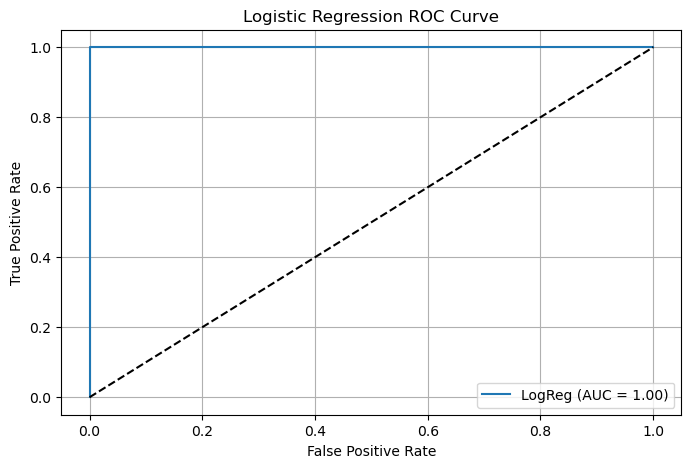

In [16]:
# Train logistic regression
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)

# Predictions
y_pred_model_lr = model_lr.predict(X_test)
y_proba_model_lr = model_lr.predict_proba(X_test)[:, 1]

# Classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_model_lr))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_model_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC AUC
roc_auc_model_lr = roc_auc_score(y_test, y_proba_model_lr)
print("Logistic Regression ROC AUC Score:", round(roc_auc_model_lr, 4))

# ROC Curve
fpr_model_lr, tpr_model_lr, _ = roc_curve(y_test, y_proba_model_lr)
plt.figure(figsize=(8, 5))
plt.plot(fpr_model_lr, tpr_model_lr, label=f'LogReg (AUC = {roc_auc_model_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Logistic Regression ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()